In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns 
import re

import tensorflow as tf
import spacy
import nltk
#nltk.download('all')

from nltk.corpus import words
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.util import ngrams
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import string

import transformers
import swifter
import contractions

pd.options.display.max_rows = 100000
pd.options.display.max_colwidth = 1000

In [21]:
def lemmatization(text):
    lem = WordNetLemmatizer()
    return " ".join([lem.lemmatize(i) for i in text.split()])

def contract_fix(text):
    return " ".join([contractions.fix(word) for word in text.split()])

def word_freq_func(corpus):
    word_freq = dict()
    for token in corpus.split():
        if token not in word_freq.keys():
            word_freq[token]=1
        else:
            word_freq[token]+= 1
        
    word_freq_df = pd.DataFrame({'words':word_freq.keys(),'values':word_freq.values()})
    word_freq_df = word_freq_df.sort_values(by='values',ascending=False)
    
    return word_freq_df

def noise_removal(text):
    return " ".join(i for i in text.split() if i not in stop_words)

def replace_char(text):
    text = text.replace('&',' and ').replace('$',' dollar ').replace('%',' percent ')
    return text

nlp = spacy.load("en_core_web_sm")
def pos_tag_filtering(text):

    doc = nlp(text)
    pos_filtered_list = [i for i in doc if i.pos_ in ['PROPN','VERB','NOUN','ADJ','ADV','AUX','CONJ','CCONJ']]
    pos_filtered_list = list(map(str,pos_filtered_list))
    return " ".join(pos_filtered_list)   
# def decode_encode(text):
#     return text.encode("ascii","ignore")

In [3]:
df = pd.read_csv('train.csv')
df_submission = pd.read_csv('test.csv')

In [4]:
print('Shape of dataset',df.shape)
print('Shape of submission dataset',df_submission.shape)

Shape of dataset (7613, 5)
Shape of submission dataset (3263, 4)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


#### Generate a crosstab between keyword and target to understand relationships and which keywords tend to have higher impact on target

In [6]:
crosstab_x = (pd.crosstab(df['keyword'],df['target'],normalize='index',margins=True)*100).sort_values(1,ascending=False)
crosstab_y = pd.crosstab(df['keyword'],df['target'],margins=True)
master_crosstab = pd.merge(crosstab_x,crosstab_y,how='inner',left_on=crosstab_x.index,right_on=crosstab_y.index,validate="one_to_one").reset_index(drop=True)
master_crosstab.columns.name = ''

# Collected list of keywords where we have more than 95% chance of the text being a disaster tweet
high_impact_keywords = master_crosstab[master_crosstab['1_x']>95]['key_0'].tolist()

In [7]:
master_crosstab.head(15)

,key_0,0_x,1_x,0_y,1_y,All
0,debris,0.000000,100.000000,0,37,37
1,wreckage,0.000000,100.000000,0,39,39
2,derailment,0.000000,100.000000,0,39,39
3,outbreak,2.500000,97.500000,1,39,40
4,typhoon,2.631579,97.368421,1,37,38
5,oil%20spill,2.631579,97.368421,1,37,38
6,suicide%20bombing,3.030303,96.969697,1,32,33
7,suicide%20bomber,3.225806,96.774194,1,30,31
8,bombing,6.896552,93.103448,2,27,29
9,rescuers,8.571429,91.428571,3,32,35


#### Creating a corpus of raw text

In [8]:
corpus_list = df['text'].tolist()
corpus = " ".join(corpus_list)
vocab = list(set(corpus.split()))

In [9]:
print('Number of unique words in the vocabulary of raw text : ',len(vocab))

Number of unique words in the vocabulary of raw text :  31924


In [10]:
print('Few words from vocabulary : \n',vocab[:10])

Few words from vocabulary : 
 ['Bolstering', 'faster.', 'Homemade', 'patient.', 'On!', 'Contact', '#straightfire', 'Fri/Sat', 'http://t.co/DQ1yLcrF9K', 'Southeast']


#### Creation of word frequency dataframe & related analysis

In [11]:
word_freq_df = word_freq_func(corpus)

In [12]:
word_freq_df.head(10)

,words,values
3,the,2575
55,a,1845
23,to,1805
25,in,1757
5,of,1722
86,and,1302
87,I,1197
213,for,820
102,is,814
83,on,773


In [13]:
#Checking frequency of mentions (@) in the tweet raw corpus
word_freq_df[word_freq_df['words'].str.startswith('@')].head(10)

,words,values
1101,@YouTube,82
1811,@,27
11312,@ArianaGrande,11
1700,@POTUS,9
1723,@Change,9
3673,@FoxNews,9
11178,@emmerdale,8
26493,@justinbieber,7
840,@djicemoon,7
27691,@Stretcher,6


In [14]:
#Checking frequency of hashtags(#) in the corpus
word_freq_df[word_freq_df['words'].str.startswith('#')].head(10)

,words,values
1060,#news,36
2881,#News,36
21018,#prebreak,30
21011,#hot,30
21019,#best,30
11624,#???,23
5224,#??,20
6280,#Hiroshima,20
6975,#GBBO,16
27946,#ISIS,11


### Target Class distribution

Text(0, 0.5, 'no. of samples')

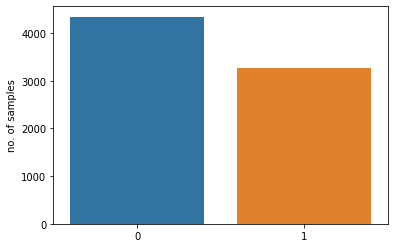

In [15]:
x=df.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('no. of samples')

### Text Pre-Processing

1. Noise Removal
2. Lexicon Normalization
3. Object Standardization

In [16]:
#Noise Removal - First we will lower the text
df['text_lowered'] = df['text'].str.lower()

#Replace apostrophe/short words in python
df['text_contraction_fixed'] = df['text_lowered'].swifter.apply(contract_fix)

#Remove http URLs from the text
df['text_url_removed'] = df['text_contraction_fixed'].swifter.apply(lambda x : re.sub(r'http\S+', '', x))

#Checking the tweets where we see punctation present
df['text_url_spclchar_removed'] = df['text_url_removed'].swifter.apply(lambda x : re.sub(r'[^&$%a-zA-Z]', ' ', x))

#Replacing few special chars with meaning
df['text_url_spclchar_removed'] = df['text_url_spclchar_removed'].swifter.apply(replace_char)

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

##### Validate if any special character

In [17]:
df['find_spcl_char'] = df['text_url_spclchar_removed'].swifter.apply(lambda x : 1 if re.search(r'[^\sa-zA-Z]',x) else 0)

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

In [18]:
df.find_spcl_char.value_counts()

0    7613
Name: find_spcl_char, dtype: int64

###### No special characters left except single space

#### Lemmatization

In [19]:
df['lemmatized_text'] = df['text_url_spclchar_removed'].swifter.apply(lemmatization)

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

#### POS Tagging

In [22]:
df['pos_filtered_text'] = df['text_url_spclchar_removed'].swifter.apply(pos_tag_filtering)

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

In [23]:
cleaned_corpus = df['pos_filtered_text'].tolist()
cleaned_corpus = " ".join(cleaned_corpus)
vocab_clean = list(set(cleaned_corpus.split()))

<b>Analyzing clean corpus

In [24]:
1 - len(vocab_clean)/len(vocab)

0.5025372760305726

In [25]:
word_freq_df_clean = word_freq_func(cleaned_corpus)

In [26]:
word_freq_df_clean.head(20)

,words,values
61,and,1884
65,is,1383
1,are,599
95,have,471
292,be,412
124,was,401
58,am,386
89,do,369
164,will,350
319,amp,344


### X-Y Split

In [27]:
x = df['pos_filtered_text']
y = df['target']

#### Train,Test Split

In [28]:

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5709,)
(1904,)
(5709,)
(1904,)


In [32]:
x_train[0]

'deeds are reason earthquake may allah forgive'

#### CountVectorizer & TF-IDF

In [29]:
# instantiate the vectorizer
vectorizer = CountVectorizer()
vectorizer.fit(x_train)

x_train_count = vectorizer.transform(x_train)
x_test_count = vectorizer.transform(x_test)

In [30]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(x_train_count)

x_train_tfidf = tfidf_transformer.transform(x_train_count)
x_test_tfidf = tfidf_transformer.transform(x_test_count)

In [31]:
x_train_count.shape

(5709, 13271)

<b> Multinomial NB

In [124]:
nb = MultinomialNB()

nb.fit(x_train_count, y_train)
y_pred_class = nb.predict(x_test_count)

In [125]:
metrics.accuracy_score(y_test, y_pred_class)

0.8025210084033614

In [126]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[957, 134],
       [242, 571]], dtype=int64)

In [128]:
x_test[y_pred_class > y_test].head(10)

4536                  wakeupflorida floridians more likely be killed injured trophyhunt killer gun isis
3861                                                                   erinmariefishy is setting flames
444                       trusting iran stop terrorism is inviting arsonist join fire brigade telegraph
1600                                      warne ponting shocked australian collapse yahoo cricket india
7223                             weapons stolen national guard armory new albany still missing gunsense
7274                                              mantra morning heading make whirlwind trip down south
4352    bayelsa poll tension bayelsa patience jonathan plans hijack apc pdp plans former first lady and
2209                                                        wa smiles july deluge west australian yahoo
2617         russian authorities take account petition destruction sanctioned food vladimir putin press
5691                                 rescued dog least years ago

In [129]:
x_test[y_pred_class < y_test].head(10)

7464                                                                                 crawling skin wounds will hea
6837                         hollywood movie trapped miners released chile hollywood movie trapped miners starring
5770                                               sweetpea s are running riot allotment and brightening rainy day
4661    ledofficial can imagine are inundated requests week samples and amp as much would love be able send sweets
4804         daviesmutia breaking news unconfirmed just heard loud bang nearby appears be blast wind neighbour ass
299                                        latest bryansinger reveals storm is queen apocalypse rupaul alexshipppp
1873                                                                                           sevenfigz has crush
6923                                                                                             god ryans trouble
7268                                                                    back sea

In [130]:
y_pred_prob = nb.predict_proba(x_test_count)[:, 1]
y_pred_prob

array([0.98061246, 0.05938338, 0.23990604, ..., 0.99999684, 0.99999623,
       0.01707699])

In [131]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.8505529418263935

<b> Multinomial NB with TF-IDF

In [133]:
nb.fit(x_train_tfidf,y_train)
y_pred_class = nb.predict(x_test_tfidf)

In [134]:
metrics.accuracy_score(y_test, y_pred_class)

0.7977941176470589

In [135]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[996,  95],
       [290, 523]], dtype=int64)

In [137]:
y_pred_prob = nb.predict_proba(x_test_tfidf)[:, 1]
y_pred_prob

array([0.70395245, 0.28634013, 0.32553158, ..., 0.8780701 , 0.8352306 ,
       0.21113163])

In [138]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.857577315461514

<b> We see slight improvement in roc_auc with Multinomial NB with TF-IDF matrix

<b>Logistic Regression

###### With CV

In [149]:
logreg = LogisticRegression(solver='liblinear')

logreg.fit(x_train_count, y_train)

LogisticRegression(solver='liblinear')

In [150]:
y_pred_class = logreg.predict(x_test_count)

In [151]:
metrics.accuracy_score(y_test, y_pred_class)

0.7935924369747899

In [152]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[960, 131],
       [262, 551]], dtype=int64)

In [153]:
y_pred_prob = nb.predict_proba(x_test_count)[:, 1]
y_pred_prob

array([0.94137283, 0.06389555, 0.20428149, ..., 0.99978985, 0.99973643,
       0.05227032])

In [154]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.850217535172602

###### Wtih TF-IDF

In [155]:
logreg.fit(x_train_tfidf, y_train)

LogisticRegression(solver='liblinear')

In [156]:
y_pred_class = logreg.predict(x_test_tfidf)

In [157]:
metrics.accuracy_score(y_test, y_pred_class)

0.7988445378151261

In [158]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[983, 108],
       [275, 538]], dtype=int64)

In [159]:
y_pred_prob = nb.predict_proba(x_test_tfidf)[:, 1]
y_pred_prob

array([0.70395245, 0.28634013, 0.32553158, ..., 0.8780701 , 0.8352306 ,
       0.21113163])

In [160]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.857577315461514

#### prediction

In [161]:
#Noise Removal - First we will lower the text
df_submission['text_lowered'] = df_submission['text'].str.lower()

#Replace apostrophe/short words in python
df_submission['text_contraction_fixed'] = df_submission['text_lowered'].swifter.apply(contract_fix)

#Remove http URLs from the text
df_submission['text_url_removed'] = df_submission['text_contraction_fixed'].swifter.apply(lambda x : re.sub(r'http\S+', '', x))

#Checking the tweets where we see punctation present
df_submission['text_url_spclchar_removed'] = df_submission['text_url_removed'].swifter.apply(lambda x : re.sub(r'[^&$%a-zA-Z]', ' ', x))

#Replacing few special chars with meaning
df_submission['text_url_spclchar_removed'] = df_submission['text_url_spclchar_removed'].swifter.apply(replace_char)

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

In [162]:
df_submission['lemmatized_text'] = df_submission['text_url_spclchar_removed'].swifter.apply(lemmatization)

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

In [165]:
df_submission['pos_filtered_text'] = df_submission['text_url_spclchar_removed'].swifter.apply(pos_tag_filtering)

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

In [168]:
x_pred = df_submission['pos_filtered_text']

In [169]:
x_pred_count = vectorizer.transform(x_pred)
x_pred_tfidf = tfidf_transformer.transform(x_pred_count)

In [170]:
df_submission['predicted_label'] = nb.predict(x_pred_tfidf)

In [172]:
df_submission['predicted_label'].value_counts()

0    2207
1    1056
Name: predicted_label, dtype: int64

In [174]:
submission = pd.read_csv('sample_submission.csv')

In [183]:
df_out = df_submission[['id','predicted_label']].rename({'predicted_label':'target'})

In [184]:
df_out.to_csv('sample_submission.csv')